# Determination of $\delta$ for exponential density

From the grid search notebook we have concluded that the more efficient computation with acceptable numerical error occurs considering the same distance-size ratii as the ones obtained in the linear density case.

This is due to the fact that when choosing default values of $D$ and $\delta$, they must ensure a good accuracy for every continuous density function. Thus the $D$ default value must not be lower than the one obtained in the linear density case.
Moreover, choosing higher a $D$ produces more discretizations on every direction, producing non efficient computation.

On this notebook we will determine default $\delta$ values while keeping the $D$ values equal to 1, 2 and 8 for the gravitational potential, its gradient and the Marussi tensor components, respectively, for both cases: a thin and a thick spherical shell.

## Determination of $\delta$: Thin Spherical Shell

**Import packages**

In [1]:
from __future__ import division
import os
import numpy as np
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt
# This is our custom tesseroid code
from tesseroid_density import tesseroid

**Create results directories**

In [2]:
result_dirs = ['results/exponential-delta']
for result_dir in result_dirs:
    try:
        os.makedirs(result_dir)
    except:
        print('Directory ' + result_dir + ' already exists.')

Directory results/exponential-delta already exists.


**Definition of analytical solution for spherical shell with exponential density**

In [3]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [4]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [5]:
shape = (19, 13)
lats, lons, heights = gridder.regular((-90, 90, 0, 360), shape, z=0)

**Compute the differences**

In [6]:
fields = 'potential gz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
delta_values = np.logspace(-3, 0, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    print(field)
    for b in b_values:
        print("b:", b)
        
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom,
                                               a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thin-differences.npz',
                 deltas=delta_values, diffs=diffs)

potential
('b:', 50)
('b:', 100)
('b:', 200)
('b:', 300)
('b:', 400)
gz
('b:', 50)
('b:', 100)
('b:', 200)
('b:', 300)
('b:', 400)


**Plot Results**

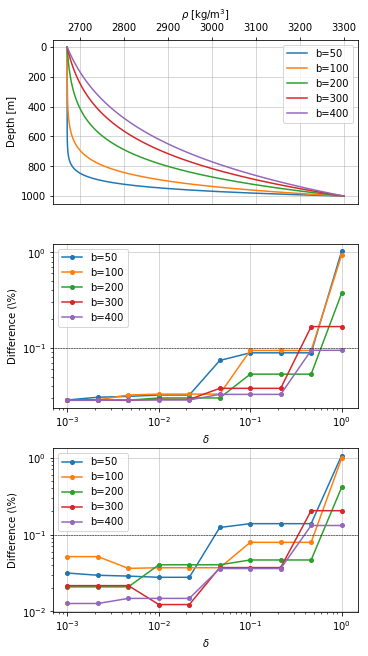

In [11]:
fields = 'potential gz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(3, 1)
fig.set_size_inches((5, 9))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thin-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

for ax in axes[1:]:
    ax.plot([1e-4, 1e1], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(7e-4, 1.5e0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"$\delta$")
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.legend()
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Determination of $\delta$: Thick Spherical Shell

**Definition of analytical solution for spherical shell with exponential density**

In [12]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [13]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [14]:
shape = (19, 13)
lats, lons, heights = gridder.regular((-90, 90, 0, 360), shape, z=0)

**Compute the differences**

In [15]:
fields = 'potential gz'.split()
b_values = [8.5e2, 5e3, 1e4, 2e4]
deltah = MEAN_EARTH_RADIUS
delta_values = np.logspace(-3, 0, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    print(field)
    for b in b_values:
        print("b:", b)
        
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom,
                                               a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thick-differences.npz',
                 deltas=delta_values, diffs=diffs)

potential
('b:', 850.0)
('b:', 5000.0)
('b:', 10000.0)
('b:', 20000.0)
gz
('b:', 850.0)
('b:', 5000.0)
('b:', 10000.0)
('b:', 20000.0)


**Plot Results**

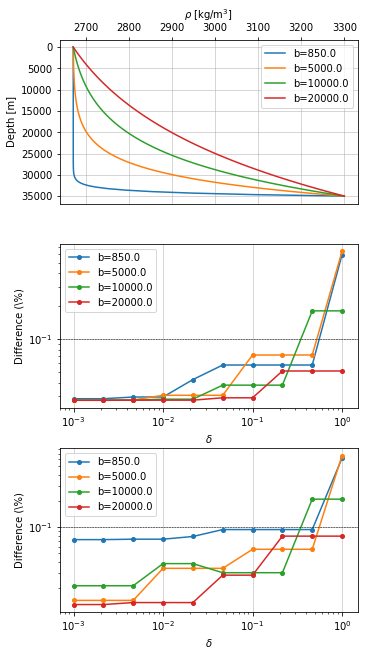

In [17]:
fields = 'potential gz'.split()
b_values = [8.5e2, 5e3, 1e4, 2e4]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(3, 1, sharex=False)
fig.set_size_inches((5, 9))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thick-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

for ax in axes[1:]:
    ax.plot([1e-4, 1e1], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(7e-4, 1.5e0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"$\delta$")
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.legend()
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()